# Ensambles

Os ensambles rapidamente se tornaram um dos métodos mais populares no aprendizado de máquina aplicado. Praticamente todas as soluções vencedoras da Kaggle as udsm, e muitos pipelines de ciência de dados têm ensambles neles. Simplificando, ensambles combinam previsões de diferentes modelos para gerar uma previsão final, e quanto mais modelos incluímos melhor será o desempenho. Melhor ainda, porque os conjuntos combinam previsões de base, eles executam pelo menos tão bem quanto o melhor modelo de linha de base. Conjuntos nos dão um aumento de desempenho quase de graça!


<img src='https://www.dataquest.io/wp-content/uploads/2019/01/network-1.png'>

Exemplo de esquemas de um conjunto. Um array de entrada X é alimentado através de dois pipelines de pré-processamento e depois para um conjunto de aprendizes de base $f(i)$. O conjunto combina todas as previsões básicas do aluno em uma matriz de previsão final P. Fonte Neste post, vamos levá-lo através do básico de conjuntos - o que são e por que eles funcionam tão bem - e fornecer um tutorial prático para a construção básica ensambles. No final, você irá:

- entender os fundamentos dos ensambles
- saber como codificá-los 
- compreender as principais armadilhas e desvantagens dos conjuntos


# Dataset de exemplo: previsão de doações republicanas e democratas

Para ilustrar como os ensambles funcionam, usaremos um conjunto de dados em contribuições políticas dos EUA. O conjunto de dados original foi preparado por Ben Wieder no FiveThirtyEight, que vasculhou o registro de contribuição política do governo dos EUA e descobriu que, quando os cientistas doam para políticos, geralmente é para os democratas. Esta afirmação baseia-se na observação sobre a parcela de doações feitas aos republicanos e democratas. No entanto, há muito mais que pode ser dito: por exemplo, qual disciplina científica é mais provável de fazer uma doação republicana, e qual estado tem maior probabilidade de fazer doações democratas? Vamos dar mais um passo e prever se é mais provável que uma doação seja para um republicano ou um democrata. Os [dados](https://s3.amazonaws.com/dq-blog-files/input.csv) que usamos aqui são ligeiramente adaptados. Removemos quaisquer doações para afiliações partidárias que não sejam democratas ou republicanas para tornar nossa exposição um pouco mais clara e descartar alguns recursos duplicados e menos interessantes. O script de dados pode ser encontrado [aqui](https://s3.amazonaws.com/dq-blog-files/gen_data.py). Aqui estão os dados:


In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv('./data/input.csv')

### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [24]:
df.cand_pty_affiliation.value_counts(1)

DEM    0.75608
REP    0.24392
Name: cand_pty_affiliation, dtype: float64

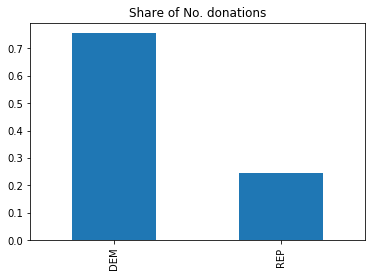

In [25]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind="bar", title="Share of No. donations")
plt.show()

A figura acima são os dados subjacentes à afirmação de Ben. De fato, entre democratas e republicanos, cerca de 75% de todas as contribuições são feitas para os democratas. Vamos analisar os recursos à nossa disposição. Temos dados sobre o doador, a transação e o destinatário:

<img src='https://www.dataquest.io/wp-content/uploads/2018/01/features.svg'>

Para medir o desempenho de nossos modelos, usamos a métrica ROC-AUC. (se esses conceitos forem novos para você, consulte a entrada da Wikipedia sobre precisão e recuperação para uma introdução rápida). Se você nunca usou essa métrica antes, um chute (aleatório) tem uma pontuação/métrica na AUC-ROC de 0,5 e a combinação perfeita de Precisão e Recall rendem 1,0.


# O que é um ensamble

Imagine que você está jogando uma [busca trivial](https://pt.wikipedia.org/wiki/Trivial_Pursuit). Quando você joga sozinho, pode haver alguns tópicos que você é bom, e alguns que você sabe quase nada sobre. Se quisermos maximizar nossa pontuação trivial, precisamos construir uma equipe para cobrir todos os tópicos. Essa é a idéia básica de um conjunto: combinar predições de vários modelos calcula a média de erros idiossincráticos (aleatórios) e produz melhores previsões gerais. Uma questão importante é como combinar previsões. Em nosso exemplo de busca trivial, é fácil imaginar que os membros da equipe possam decidir e a maioria decide o que escolher. O aprendizado de máquina é notavelmente semelhante em problemas de classificação: tomar a predição de etiqueta de classe mais comum é equivalente a uma regra de votação majoritária. Mas há muitas outras maneiras de combinar previsões e, de maneira mais geral, podemos usar um modelo para aprender a melhor maneira de combinar previsões.


<img src='https://www.dataquest.io/wp-content/uploads/2019/01/ensemble_network.png'>

fonte: http://flennerhag.com/2017-04-18-introduction-to-ensembles/

# Entendendo ensambles e combinando árvores de decisão

Para ilustrar o maquinário dos conjuntos, começaremos com um modelo interpretável simples: uma árvore de decisão, que é uma árvore de regras if-then. Se você não estiver familiarizado com as árvores de decisão ou quiser mergulhar mais fundo, confira o curso de árvores de decisão no Dataquest. Quanto mais profunda a árvore, mais complexos são os padrões que ela pode capturar, mas os mais propensos ao overfitting serão. Por causa disso, precisaremos de uma maneira alternativa de construir modelos complexos de árvores de decisão, e um conjunto de diferentes árvores de decisão é uma dessas maneiras. Usaremos a função auxiliar abaixo para visualizar nossas regras de decisão:

In [ ]:
# !pip install requirements.txt

In [27]:
# !pip freeze requirements.txt

In [6]:
# !pip install pydotplus

In [28]:
import pydotplus  # you can install pydotplus with: pip install pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

Vamos ajustar uma árvore de decisão com um único nó (regra de decisão) em nossos dados de treinamento e ver como ela se comporta no conjunto de testes:

Decision tree ROC-AUC score: 0.672


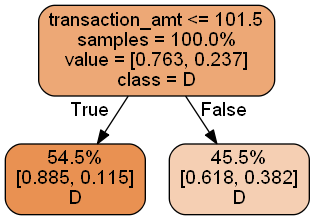

In [29]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

Cada uma das duas folhas registra sua parcela de amostras de treinamento, a distribuição de classes dentro de sua participação e a previsão do rótulo de classe. Nossa árvore de decisão baseia sua previsão sobre se o tamanho da contribuição está acima de 101,5: mas faz a mesma previsão independentemente! Isto não é muito surpreendente, dado que 75% de todas as doações são para os democratas. Mas não está fazendo uso dos dados que temos. Vamos usar três níveis de regras de decisão e ver o que podemos obter:


Decision tree ROC-AUC score: 0.751


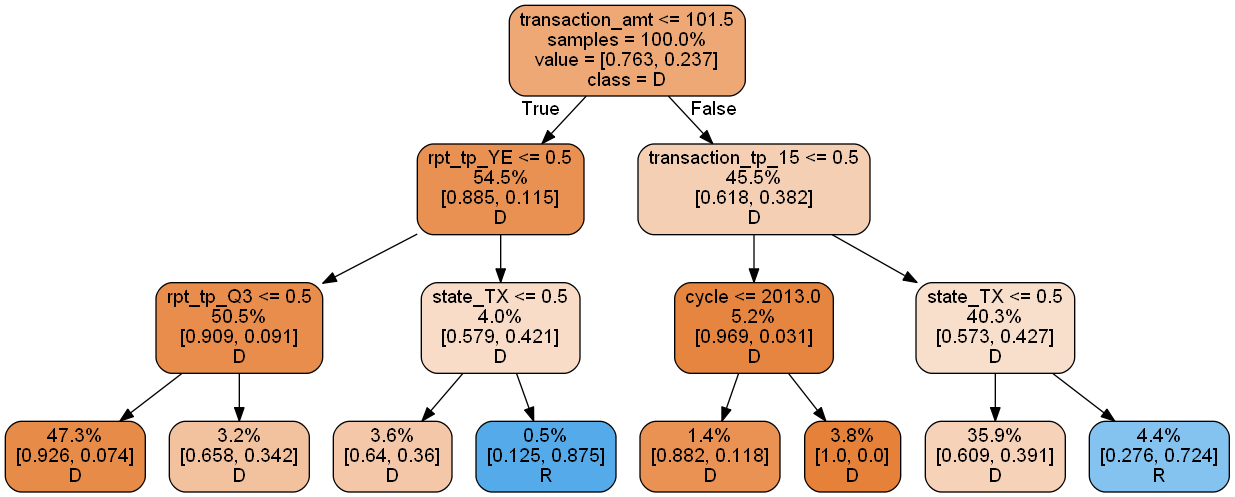

In [30]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

Este modelo não é muito melhor do que a simples árvore de decisão: estima-se que 5% de todas as doações vão para os republicanos - bem menos do que os 25% esperados. Um olhar mais atento nos diz que a árvore de decisão usa algumas regras dúbias de divisão. Um gritante 47,3% de todas as observações acabam na folha mais à esquerda, enquanto outros 35,9% acabam na segunda folha à direita. A grande maioria das folhas é, portanto, irrelevante. Tornar o modelo mais profundo apenas faz com que ele se sobreponha. Ao fixar a profundidade, uma árvore de decisão pode se tornar mais complexa aumentando a “largura”, ou seja, criando várias árvores de decisão e combinando-as. Em outras palavras, um conjunto de árvores de decisão. Para ver por que esse modelo ajudaria, considere como podemos forçar uma árvore de decisão a investigar outros padrões que não os da árvore acima. A solução mais simples é remover recursos que aparecem no início da árvore. Suponha, por exemplo, que removamos o recurso de quantidade de transação (transaction_amt), a raiz da árvore. Nossa nova árvore de decisão ficaria assim:


Decision tree ROC-AUC score: 0.740


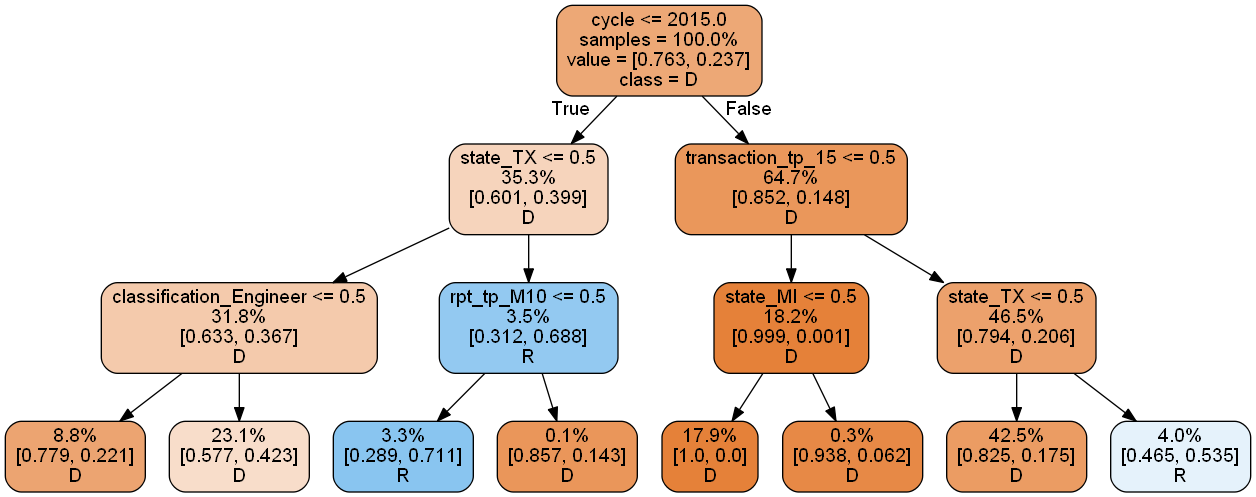

In [31]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

O escore ROC-AUC é semelhante, mas a parcela da doação republicana aumentou para 7,3%. Ainda muito baixo, mas mais alto que antes. É importante ressaltar que, em contraste com a primeira árvore, onde a maioria das regras relacionadas à transação em si, essa árvore é mais focada na residência do candidato. Agora temos dois modelos que por si só têm poder preditivo similar, mas operam com regras diferentes. Por causa disso, é provável que eles cometam erros de previsão diferentes, o que podemos calcular com um conjunto.

# Interlúdio: por que as previsões de média funcionam

Por que esperamos que as previsões da média funcionem? Considere um exemplo de  comttreinamento com duas observações para as quais queremos gerar previsões. O verdadeiro rótulo para a primeira observação é o republicano, e o verdadeiro rótulo para a segunda observação é o democrata. Neste exemplo de brinquedo, suponha que o modelo 1 esteja propenso a predizer o democrata, enquanto o modelo 2 está propenso a predizer o republicano, como na tabela abaixo:

<img src='./img/tab1.png'>

Se usarmos a regra padrão de corte de 50% para fazer uma previsão de classe, cada árvore de decisão recebe uma observação correta e outra errada. Criamos um conjunto calculando a média das probabilidades de classe do modelo, que é um voto majoritário ponderado pela força (probabilidade) da previsão do modelo. Em nosso exemplo de brinquedo, o modelo 2 tem certeza de sua previsão para a observação 1, enquanto o modelo 1 é relativamente incerto. Ponderando suas previsões, o conjunto favorece o modelo 2 e prevê corretamente o republicano. Para a segunda observação, as tabelas são giradas e o conjunto prevê corretamente o democrata:


<img src='./img/tab2.png'>

Com mais de duas árvores de decisão, o conjunto prevê de acordo com a maioria. Por essa razão, um conjunto que calcula a média das previsões dos classificadores é conhecido como um classificador de votação por maioria . Quando uma média de conjuntos é baseada em probabilidades (como acima), nós nos referimos a ela como soft vote , calculando a média das previsões finais de etiqueta de classe é conhecido como hard vote [para mais detalhes dessa diferença](https://stats.stackexchange.com/questions/349540/hard-voting-soft-voting-in-ensemble-based-methods). Claro, os conjuntos não são uma bala de prata. Você deve ter notado em nosso exemplo de brinquedo que, para calcular a média para o trabalho, os erros de previsão devem ser não correlacionados. Se ambos os modelos fizessem previsões incorretas, o conjunto não seria capaz de fazer nenhuma correção. Além disso, no esquema de votação flexível, se um modelo faz uma previsão incorreta com um valor de alta probabilidade, o conjunto seria sobrecarregado. Geralmente, os grupos não conseguem todas as observações corretas, mas a expectativa é melhor do que os modelos subjacentes.


# Uma floresta é um conjunto de árvores

Voltando ao nosso problema de previsão, vamos ver se podemos construir um conjunto de nossas duas árvores de decisão. Primeiro, verificamos a correlação de erros: erros altamente correlacionados resultam em conjuntos desfavoráveis.

In [36]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

t_results = pd.DataFrame({"full_data": p1,
              "red_data": p2})

t_results.head()

,full_data,red_data
0,0.390747,0.423244
1,0.073635,0.000000
2,0.390747,0.220957
3,0.073635,0.000000
4,0.073635,0.000000


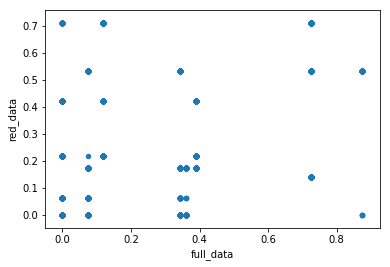

In [40]:
t_results.plot.scatter(x='full_data', y = 'red_data')

In [41]:
# t_results.full_data.plot.hist(bins=10)

In [42]:
pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


In [44]:
# np.random.int(0,1,xtest.shape[0])

Existe alguma correlação, mas não excessivamente: ainda há uma boa quantidade de variância de previsão para explorar. Para construir nosso primeiro conjunto, simplesmente calculamos a média das previsões dos dois modelos.


In [48]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.10f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.7827424568


In [49]:
p1_ = 0.751
p2_ = 0.74

In [52]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1*(p2_/(p1_+p2_)), p2*(p1_/(p1_+p2_))], axis=0)
print("Average of decision tree ROC-AUC score: %.10f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.7838733013


De fato, o procedimento conjunto leva a um aumento da pontuação. Mas talvez se tivéssemos árvores mais diversas, poderíamos obter um ganho ainda maior. Como devemos escolher quais recursos excluir ao projetar as árvores de decisão? Uma abordagem rápida que funciona bem na prática é selecionar aleatoriamente um subconjunto de recursos, ajustar uma árvore de decisão em cada sorteio e calcular a média de suas previsões. Esse processo é conhecido como média de bootstrap (geralmente abreviado bagging) e, quando aplicado a árvores de decisão, o modelo resultante é uma Random Forest. Vamos ver o que uma floresta aleatória pode fazer por nós. Usamos a implementação do Scikit-learn e construímos um conjunto de 10 árvores de decisão, cada uma montada em um subconjunto de 3 recursos.


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


In [58]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features=3,
    random_state=SEED)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.869


In [60]:
# print(f"Average of decision tree ROC-AUC score: {round(roc_auc_score(ytest, p),6)}")

A Floresta Aleatória produz uma melhoria significativa em nossos modelos anteriores. Estamos indo para algo! Mas há muito o que você pode fazer com as árvores de decisão. É hora de expandir nosso horizonte.

# Ensambles como previsões médias

    1) Quanto menor a correlação nos erros de previsão, melhor
    2) Quanto mais modelos, melhor
    
Por esse motivo, é uma boa ideia usar modelos diferentes (contanto que eles funcionem decentemente). Até agora, confiamos na média simples, mas depois veremos como usar combinações mais complexas. Para acompanhar o nosso progresso, é útil formalizar o nosso conjunto como n modelos fi em média em um conjunto

Não há limitação em quais modelos incluir: árvores de decisão, modelos lineares, modelos baseados em kernel, modelos não paramétricos, redes neurais ou até mesmo outros conjuntos! Tenha em mente que quanto mais modelos incluímos, mais lento fica o conjunto. Para construir um conjunto de vários modelos, começamos comparando um conjunto de classificadores do Scikit-learn no conjunto de dados. Para evitar a repetição do código, usamos as funções auxiliares abaixo:

In [62]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = []
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

Agora, estamos prontos para criar uma matriz de previsão P, em que cada recurso corresponde às previsões feitas por um determinado modelo e classificar cada modelo com relação ao conjunto de testes:


In [63]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... 

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... 

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
mlp-nn                    : 0.873
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



Essa é nossa linha de base. O Gradient Boosting Machine (GBM) é o melhor, seguido por uma simples regressão logística. Para que a nossa estratégia de conjunto funcione, os erros de previsão devem ser relativamente não correlacionados. Verificar se isso é nosso primeiro pedido:


In [76]:
!pip install mlens

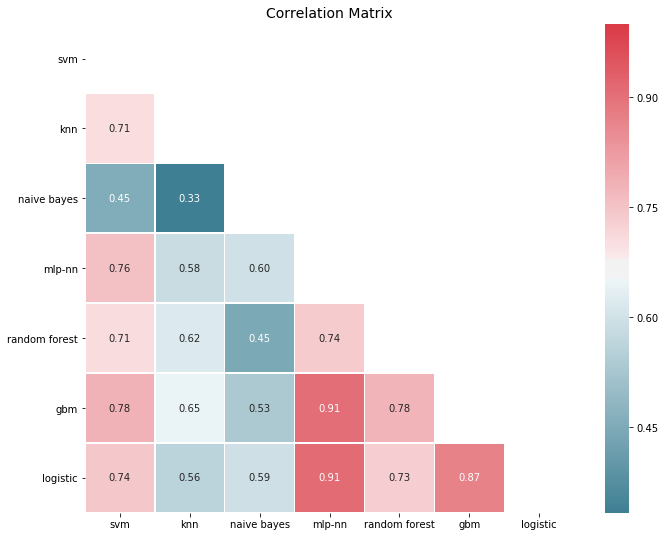

In [77]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
from mlens.visualization import corrmat 

corrmat(P.corr(), inflate=False)

plt.show()

Os erros são significativamente correlacionados, o que é esperado para os modelos que apresentam bom desempenho, pois normalmente são os valores discrepantes que são difíceis de acertar. No entanto, a maioria das correlações está na faixa de 50 a 80%, portanto, há espaço decente para melhorias. De fato, se olharmos para as correlações de erro em uma base de predição de classe, as coisas parecem um pouco mais promissoras:


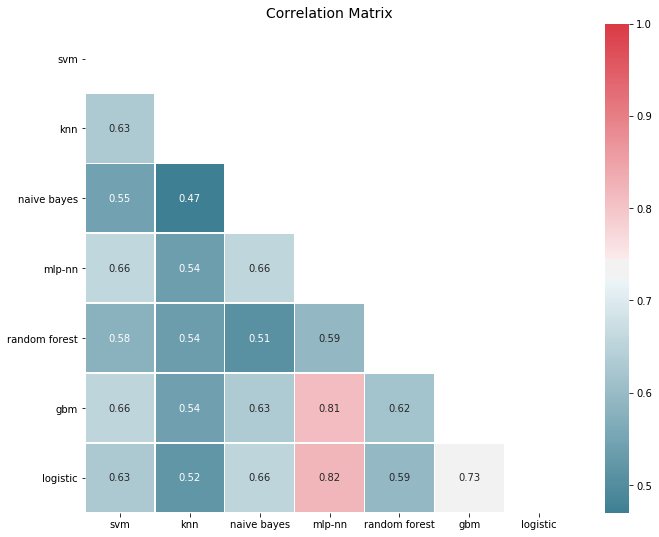

In [78]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

Para criar um conjunto, procedemos como antes e previsões médias, e como poderíamos esperar, o conjunto supera a linha de base. A média é um processo simples e, se armazenarmos as previsões do modelo, podemos começar com um conjunto simples e aumentar seu tamanho enquanto treinamos novos modelos.


In [79]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.885


# Visualizando como os ensambles funcionam 

Entendemos o poder dos conjuntos como um mecanismo de correção de erros. Isso significa que os conjuntos suavizam os limites de decisão, calculando a média das irregularidades. Um limite de decisão nos mostra como um estimador divide o espaço de características em uma vizinhança dentro da qual todas as observações têm o mesmo rótulo de classe. Ao calcular a média dos limites básicos de decisão do aluno, o conjunto é dotado de um limite mais suave que generaliza mais naturalmente. A figura abaixo mostra isso em ação. Aqui, o exemplo é o conjunto de dados da íris, onde os estimadores tentam classificar três tipos de flores. Todos os aprendizes de base têm algumas propriedades indesejáveis ​​em seus limites, mas o conjunto tem um limite de decisão relativamente suave que se alinha com as observações. Surpreendentemente, os conjuntos aumentam a complexidade do modelo e atuam como um regularizador!

<img src='https://www.dataquest.io/wp-content/uploads/2019/01/ensemble_decision_regions_2d.jpg'>

Outra maneira de entender o que está acontecendo em um conjunto quando a tarefa é a classificação é inspecionar a Curva do Operador do Receptor (Receiver Operator Curve - ROC). Essa curva nos mostra como um estimador troca a precisão e a recordação. Tipicamente, diferentes aprendizes de base fazem trocas diferentes: alguns têm maior precisão ao sacrificar a recordação, e outros têm maior recordação sacrificando a precisão. Um meta-aprendente não linear, por outro lado, é capaz de, para cada ponto de treinamento, ajustar em quais modelos se baseia. Isso significa que pode reduzir significativamente os sacrifícios necessários e reter alta precisão enquanto aumenta o recall (ou vice-versa). Na figura abaixo, o conjunto está fazendo um sacrifício muito menor em precisão para aumentar a recordação (o ROC está mais além no canto "nordeste").


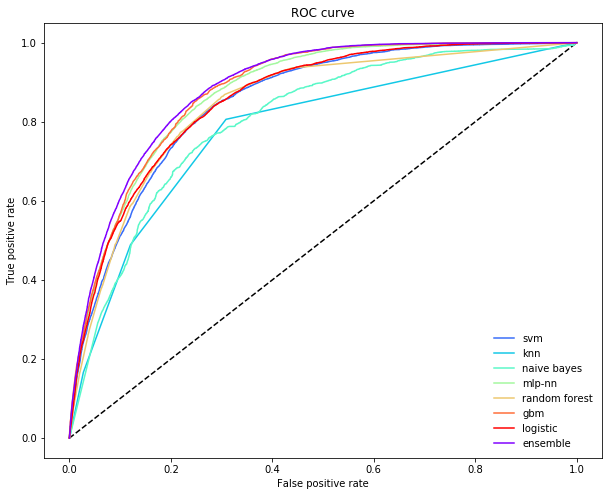

In [81]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

# Além dos ensembles como uma média simples

Mas você não esperaria mais de um aumento, dada a variação nos erros de previsão? Bem, uma coisa é um pouco irritante. Alguns dos modelos têm desempenho consideravelmente pior do que outros, mas sua influência é grande como modelos com melhor desempenho. Isso pode ser bastante devastador com conjuntos de dados desbalanceados: lembre-se de que, com o voto flexível, se um modelo faz uma previsão extrema (ou seja, próximo a 0 ou 1), essa previsão tem um forte impacto na média de previsão. Um fator importante para nós é se os modelos são capazes de captar toda a parcela de denotações republicanas. Uma simples verificação mostra que todos os modelos subrepresentam doações republicanas, mas alguns são consideravelmente piores que outros.


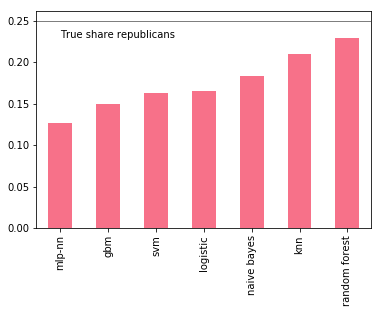

In [82]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))

p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

Podemos tentar melhorar o conjunto removendo o pior agressor, digamos o Multi-Layer Perceptron (MLP):


In [83]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


Não é realmente uma melhoria: precisamos de uma maneira mais inteligente de priorizar os modelos. Claramente, remover modelos de um conjunto é bastante drástico, pois pode haver casos em que o modelo removido tenha informações importantes. O que realmente queremos é aprender um conjunto sensato de pesos para usar quando calcular a média das previsões. Isso transforma o conjunto em um modelo paramétrico que precisa ser treinado.


# Aprendendo a combinar previsões 

Aprender uma média ponderada significa que para cada modelo fi, temos um parâmetro de peso ωi∈ (0,1) que atribui nosso peso às previsões desse modelo. A média ponderada requer que todos os pesos sejam somados para 1. O conjunto agora é definido como e (x) = ∑i = 1nωi fi (x). Esta é uma pequena alteração da nossa definição anterior, mas é interessante, uma vez que, uma vez que os modelos geraram previsões pi = fi (x), aprender os pesos é o mesmo que ajustar uma regressão linear nessas previsões: e (p1,…, pn ) = ω1p1 +… + ωnpn, com algumas restrições nos pesos. Então, novamente, não há razão para nos restringirmos a apenas um modelo linear. Suponha, em vez disso, que nos ajustemos a um modelo vizinho mais próximo. O conjunto levaria as médias locais com base nos vizinhos mais próximos de uma dada observação, capacitando o conjunto a se adaptar às mudanças no desempenho do modelo à medida que a entrada varia.

Implementando um ensamble

Para construir esse tipo de conjunto, precisamos de três coisas: 

    1) uma biblioteca de alunos de base que geram previsões
    2) um meta aprendiz que aprende a melhor maneira de combinar essas previsões
    3) um método para dividir os dados de treinamento entre os alunos de base e o meta aprendente.
    
    
Os "learners" de base são os modelos ingoing que pegam a entrada original e geram um conjunto de previsões. Se tivermos um conjunto de dados original ordenado como uma matriz X de forma (n_samples, n_features), a biblioteca de alunos de base gerará uma nova matriz de predição Pbase de tamanho (n_samples, n_base_learners), onde cada coluna representa as previsões feitas por um dos alunos de base. O meta aprendiz é treinado em Pbase. Isso significa que é absolutamente crucial lidar com o conjunto de treinamento X de maneira apropriada. Em particular, se ambos treinarmos os alunos de base em X e fizerem com que eles prediguem X, o meta aprendiz estará treinando no erro de treinamento do aluno de base, mas no tempo de teste ele enfrentará os erros de teste. Precisamos de uma estratégia para gerar uma matriz de previsão P que reflita erros de teste. A estratégia mais simples é dividir o conjunto de dados completo X em dois: treinar os alunos de base em uma metade e fazer com que eles prevejam a outra metade, que então se torna a entrada para o meta aprendente. Embora simples e relativamente rápido, perdemos bastante dados. Para conjuntos de dados de pequeno e médio porte, a perda de informações pode ser grave, fazendo com que os alunos de base e o meta aprendente tenham um desempenho ruim. Para garantir que todo o conjunto de dados seja coberto, podemos usar a validação cruzada, um método desenvolvido inicialmente para validar o desempenho do conjunto de testes durante a seleção do modelo. Há muitas maneiras de realizar a validação cruzada e, antes de nos aprofundarmos nisso, vamos entender esse tipo de conjunto implementando uma delas, passo a passo.    


# Etapa 1: definir uma biblioteca de learners de base

Esses são os modelos que pegam os dados de entrada brutos e geram previsões, e podem ser qualquer coisa, desde a regressão linear até uma rede neural para outro conjunto. Como sempre, há força na diversidade! A única coisa a considerar é que quanto mais modelos adicionarmos, mais lento será o conjunto. Aqui, usaremos nosso conjunto de modelos de antes:



In [89]:
# type(svm)

In [87]:
base_learners = get_models()

# Etapa 2: definir um meta aprendiz

Qual meta-aprendente usar não é óbvio, mas escolhas populares são modelos lineares, modelos baseados em kernel (SVMs e KNNS) e modelos baseados em árvore de decisão. Mas você também pode usar outro conjunto como "meta aprendente": neste caso especial, você acaba com um conjunto de duas camadas, semelhante a uma rede neural de feed-forward. Aqui, usaremos uma máquina de aumento de gradiente. Para garantir que o GBM explore os padrões locais, estamos restringindo cada uma das 1000 árvores de decisão a treinar em um subconjunto aleatório de 4 alunos de base e 50% dos dados de entrada. Dessa forma, o GBM será exposto à força de cada aluno básico em diferentes vizinhanças do espaço de entrada.



In [103]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED)

# Etapa 3: defina um procedimento para gerar conjuntos de trens e testes

Para simplificar, dividimos o conjunto completo de treinamento em um conjunto de treinamento e previsão dos alunos de base. Este método é por vezes referido como Blending. Infelizmente, a terminologia difere entre comunidades, por isso nem sempre é fácil saber que tipo de validação cruzada o conjunto está usando.



In [90]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

Agora temos um conjunto de treinamento dos alunos de base (Xtrain_base, ytrain_base) e um conjunto de previsão (Xpred_base, ypred_base) e estamos prontos para gerar a matriz de previsão para o meta aprendente.

# Etapa 4: treinar os leaners de base em um conjunto de treinamento

Para treinar a biblioteca de alunos de base nos dados de treinamento do aluno de base, procedemos como de costume:

In [91]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """
    Train all base learners in the library.
    """
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

Para treinar os learners de base, execute

In [95]:
xtrain_base.fillna(0, inplace=True)

C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [96]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... 

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Etapa 5: gerar previsões básicas de alunos

Com os alunos de base instalados, agora podemos gerar um conjunto de previsões para o aprendiz de meta treinar. Observe que geramos previsões para observações não usadas para treinar os alunos de base. Para cada observação xpred (i) ∈Xpred_base no conjunto de previsão do aluno de base, geramos um conjunto de predições de alunos de base: pbase (i) = (f1 (xpred (i)),…, fn (xpred (i))). Se você implementar seu próprio conjunto, preste especial atenção em como indexar as linhas e colunas da matriz de previsão. Quando dividimos os dados em dois, isso não é tão difícil, mas as validações cruzadas são mais desafiadoras.

In [108]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """
    Generate a prediction matrix.
    """
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

Para gerar previsões, execute

In [109]:
xpred_base.fillna(0, inplace=True)

C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [100]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


# 6. Treine o meta learner

A matriz de predição Pbase reflete o desempenho em tempo de teste e pode ser usada para treinar o meta aprendiz:

In [110]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=222,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

É isso aí! Agora temos um conjunto totalmente treinado que pode ser usado para prever novos dados. Para gerar uma previsão para alguma observação x (j), primeiro a alimentamos aos alunos de base. Estes produzem um conjunto de predições pbase (j) = (f1 (x (j)), ..., fn (x (j))) que alimentamos ao meta-aprendente. O metamercador então nos dá a previsão final do conjunto p (j) = m (pbase (j)). Agora que temos uma sólida compreensão da aprendizagem conjunta, é hora de ver o que ela pode fazer para melhorar nosso desempenho de previsão no conjunto de dados de contribuições políticas:

In [111]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """
    Generate predictions from the ensemble.
    """
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

Para gerar previsões, execute

In [112]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.881


Como esperado, o conjunto supera o melhor estimador do nosso benchmark anterior, mas não supera o conjunto médio simples. Isso é porque treinamos os alunos de base e o meta aprendente em apenas metade dos dados, por isso muitas informações são perdidas. Para evitar isso, precisamos usar uma estratégia de validação cruzada.

# Treinamento com validação cruzada

Durante o treino de validação cruzada dos alunos de base, uma cópia de cada aluno de base é colocada em dobras K − 1 e prevê a dobra deixada de fora. Este processo é iterado até que cada dobra seja prevista. Quanto mais dobras especificarmos, menos dados serão deixados de fora em cada passagem de treinamento. Isso faz previsões cruzadas menos ruidosas e uma melhor reflexão do desempenho durante o tempo de teste. O custo é significativamente maior tempo de treinamento. A montagem de um conjunto com validação cruzada é muitas vezes referida como empilhamento, enquanto o próprio conjunto é conhecido como o Super aprendiz. Para entender como funciona a validação cruzada, podemos pensar nisso como um loop externo ao nosso conjunto anterior. O loop externo itera sobre K dobras de teste distintas, com os dados restantes usados ​​para treinamento. O loop interno treina os alunos de base e gera previsões para os dados que estão fora. Veja uma implementação simples de empilhamento:

In [114]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

Vamos passar pelas etapas envolvidas aqui. Em primeiro lugar, ajustamos nossos aprendizes finais em todos os dados: em contraste com nosso conjunto de mesclagem anterior, os alunos de base usados ​​no tempo de teste são treinados em todos os dados disponíveis. Em seguida, fazemos o loop de todas as dobras e, em seguida, percorremos todos os alunos de base para gerar previsões validadas de forma cruzada. Essas previsões são empilhadas para criar o conjunto de treinamento para o meta aprendente, que também vê todos os dados. A diferença básica entre mesclagem e empilhamento é, portanto, que o empilhamento permite que os aprendizes de base e o meta-aprendiz treinem no conjunto de dados completo. Usando a validação cruzada em duas etapas, podemos medir a diferença que isso faz no nosso caso:


In [115]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
Generating cross-validated predictions...


C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 done


C:\Users\marco\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


O empilhamento/stacking gera um aumento considerável no desempenho: na verdade, isso nos dá a melhor pontuação até o momento. Esse resultado é típico para conjuntos de dados pequenos e médios, em que o efeito da mesclagem pode ser grave. À medida que o tamanho do conjunto de dados aumenta, a mesclagem e o empilhamento ocorrem de maneira semelhante. O empilhamento vem com seu próprio conjunto de defeitos, particularmente velocidade. Em geral, precisamos estar cientes de questões importantes quando se trata de implementar conjuntos com validação cruzada:


    1) Complexidade computacional 
    2) Complexidade estrutural (risco de vazamento de informações) 
    3) Consumo de memória 

É importante entender isso para trabalhar com os grupos de maneira eficiente, então vamos passar por cada um deles.

# 1. Complexidade computacional

Suponha que queremos usar 10 dobras para o empilhamento. Isso exigiria treinar todos os alunos básicos 10 vezes em 90% dos dados e uma vez em todos os dados. Com 4 alunos de base, o conjunto seria aproximadamente 40 vezes mais lento do que usando o melhor aluno de base. Mas cada ajuste de cv é independente, por isso não precisamos ajustar modelos sequencialmente. Se pudéssemos encaixar todas as dobras em paralelo, o conjunto seria apenas cerca de 4 vezes mais lento que o melhor aluno de base, uma melhoria dramática. Conjuntos são os principais candidatos para a paralelização, e é fundamental aproveitar essa capacidade na maior medida possível. Ajustando todas as dobras para todos os modelos em paralelo, a penalidade de tempo para o conjunto seria insignificante. Para aprimorar este ponto, abaixo está uma referência do ML-Ensemble que mostra o tempo que leva para encaixar um conjunto via empilhamento ou mistura sequencial ou paralela em 4 threads.

<img src='https://www.dataquest.io/wp-content/uploads/2019/01/scale_cpu-1.png'>

Mesmo com esse grau moderado de paralelismo, podemos perceber uma redução considerável no tempo de computação. Mas a paralelização está associada a toda uma série de problemas potencialmente espinhosos, como condições de corrida, impasses e explosão de memória.


# 2. Complexidade Estrutural

Quando decidimos usar todo o conjunto de treinamento para o meta aprendente, devemos nos preocupar com o vazamento de informações. Esse fenômeno surge quando nós prevemos erroneamente amostras que foram usadas durante o treinamento, por exemplo, misturando nossas dobras ou usando um modelo treinado no subconjunto errado. Quando houver vazamento de informações no conjunto de treinamento do meta aprendiz, ele não aprenderá a corrigir adequadamente os erros de previsão dos alunos de base: entrada de lixo, saída de lixo. Identificar esses bugs é extremamente difícil.


# 3. Consumo de memória

A questão final surge com a paralelização, especialmente pelo multi-processamento, como é frequentemente o caso em Python. Nesse caso, cada subprocesso possui sua própria memória e, portanto, precisa copiar todos os dados do processo pai. Uma implementação ingênua, portanto, copiará todos os dados para todos os processos, consumindo memória e perdendo tempo na serialização dos dados. Evitar isso requer o compartilhamento de memória de dados, o que, por sua vez, causa facilmente corrupção de dados.

# Upshot: use pacotes

O resultado é que você deve usar um pacote testado por unidade e focar na construção de seu pipeline de aprendizado de máquina. De fato, uma vez que você se estabeleceu em um pacote conjunto, os conjuntos de construção tornam-se realmente fáceis: tudo que você precisa fazer é especificar os alunos de base, o meta aprendiz e um método para treinar o conjunto. Felizmente, existem muitos pacotes disponíveis em todas as linguagens de programação populares, apesar de virem em diferentes sabores. No final deste post, listamos alguns como referência. Por enquanto, vamos escolher um e ver como um conjunto empilhado faz em nosso conjunto de dados de contribuições políticas. Aqui, usamos o ML-Ensemble e construímos nosso conjunto generalizado anterior, mas agora usando validação cruzada de 10 vezes:


In [121]:
import numpy as np

In [2]:
# xtrain.replace([np.inf, -np.inf], 0)

In [4]:
# xtrain.fillna(0, inplace=True)

In [5]:
# xtrain.dtypes

In [3]:
# for column in xtrain.columns:
#     xtrain[column] = xtrain[column].astype('float64')

In [139]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True, propagate_features=xtrain.columns)

sl.add_meta(meta_learner, proba=True)

Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))

É simples assim! Inspecionar a curva ROC do super aprendiz contra o conjunto médio simples revela como a alavancagem dos dados completos permite que o super aprendiz sacrifique menos recordações para um dado nível de precisão.


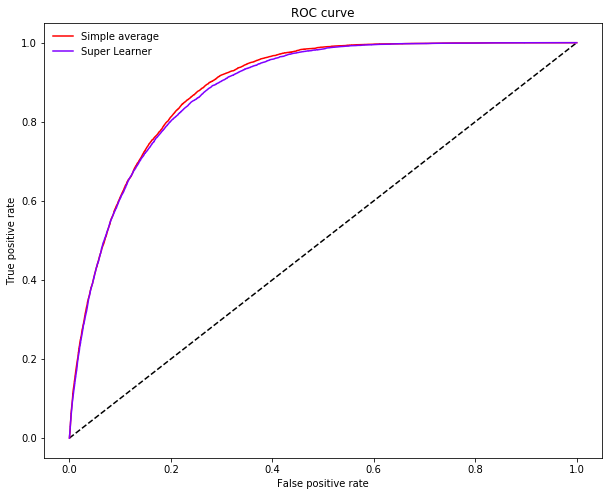

In [140]:
plot_roc_curve(ytest,
               p.reshape(-1, 1),
               P.mean(axis=1),
               ["Simple average"],
               "Super Learner")